# 15-9. 프로젝트 : 다양한 OCR모델 비교하기

In [1]:
# 프로젝트를 시작하기 전에 주요 라이브러리 버전을 살펴보기
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


## Step1. 검증용 데이터셋 준비

테스트용 이미지 데이터를 12개 준비하였음.

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/ocr_python/images'
files = os.listdir(file_path)
files

['test_12.jfif',
 'test_3.jfif',
 'test_5.jfif',
 'test_4.jfif',
 'test_9.jfif',
 'test_2.jfif',
 'test_8.jfif',
 'test_11.jfif',
 'test_6.jfif',
 'test_1.jfif',
 'test_7.jfif',
 'test_10.jfif']

## Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

### keras-ocr

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
images = [keras_ocr.tools.read(os.path.join(file_path, file)) for file in files]
prediction_groups = [pipeline.recognize([os.path.join(file_path, file)]) for file in files]

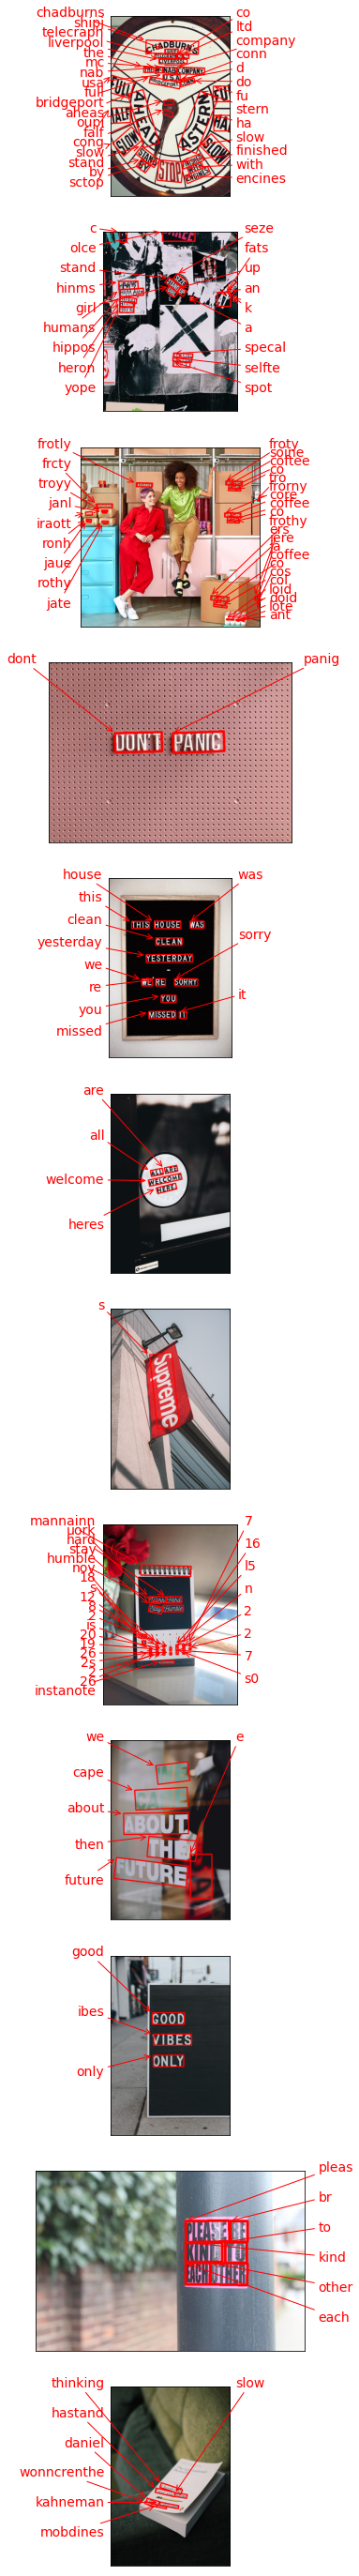

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [6]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

In [7]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.


#  crop_word_regions() : 테스트 이미지를 받아, 문자 검출을 진행 후, 검출된 문자 영역을 crop한 이미지로 만들어 파일들의 list를 리턴하는 함수
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    
# pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정    
    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

* 위에서 구현한 crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다.

* 기본적으로 pytesseract.image_to_data() 를 사용합니다.<br>파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정해 주게 됩니다.<br> 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 됩니다.<br> 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴하였습니다.

In [8]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images'
img_file_path = work_dir + '/test_5.jfif'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명. 
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/images/0000.png
/aiffel/aiffel/ocr_python/images/0001.png
/aiffel/aiffel/ocr_python/images/0002.png
/aiffel/aiffel/ocr_python/images/0003.png
/aiffel/aiffel/ocr_python/images/0004.png
/aiffel/aiffel/ocr_python/images/0005.png
/aiffel/aiffel/ocr_python/images/0006.png
/aiffel/aiffel/ocr_python/images/0007.png
/aiffel/aiffel/ocr_python/images/0008.png
/aiffel/aiffel/ocr_python/images/0009.png
/aiffel/aiffel/ocr_python/images/0010.png
/aiffel/aiffel/ocr_python/images/0011.png
/aiffel/aiffel/ocr_python/images/0012.png


In [9]:
# 테서랙트로 잘린 이미지에서 단어 인식하기
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

PREDERY

A

COFFEE

to.

rico rin’

beh

COFFEE

ae

rROTRY

JO RE

COFFEE

CoO.

er.

Done


## Step3. 테스트 결과 정리

### 원본 이미지
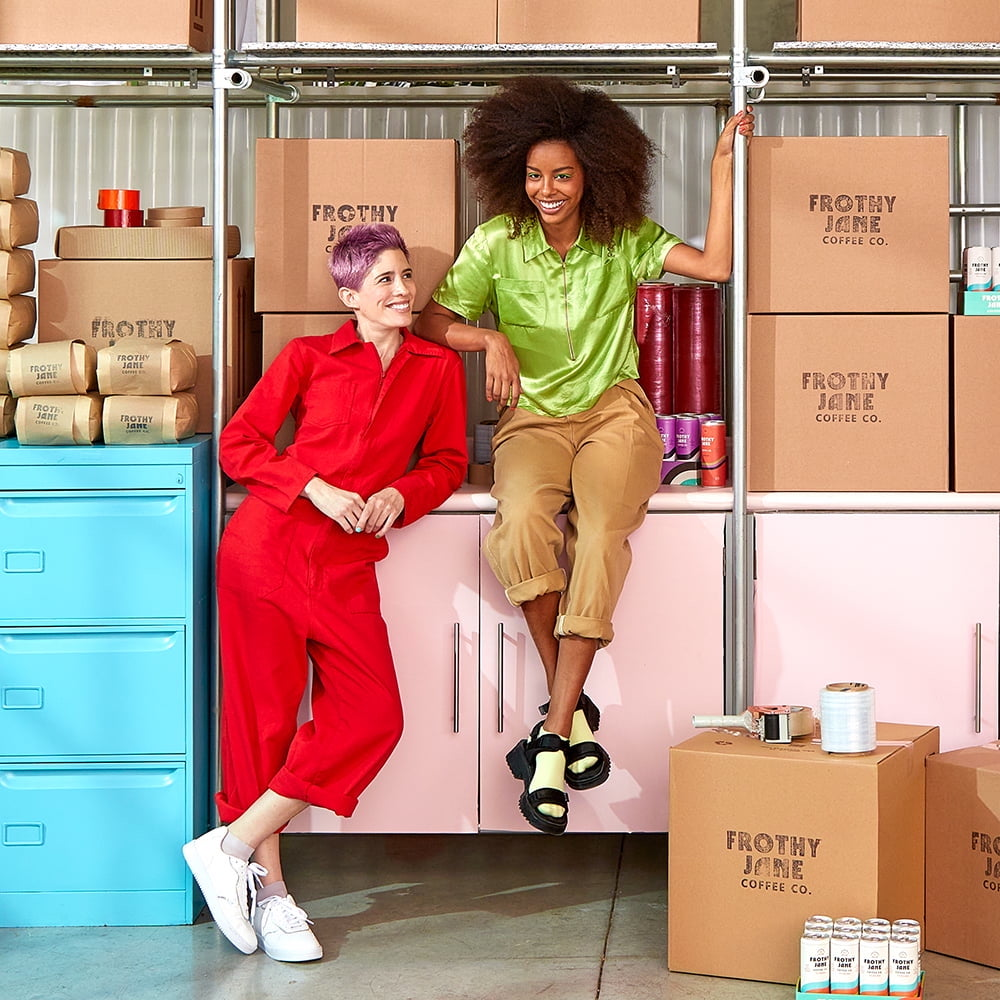

### keras-ocr 사용

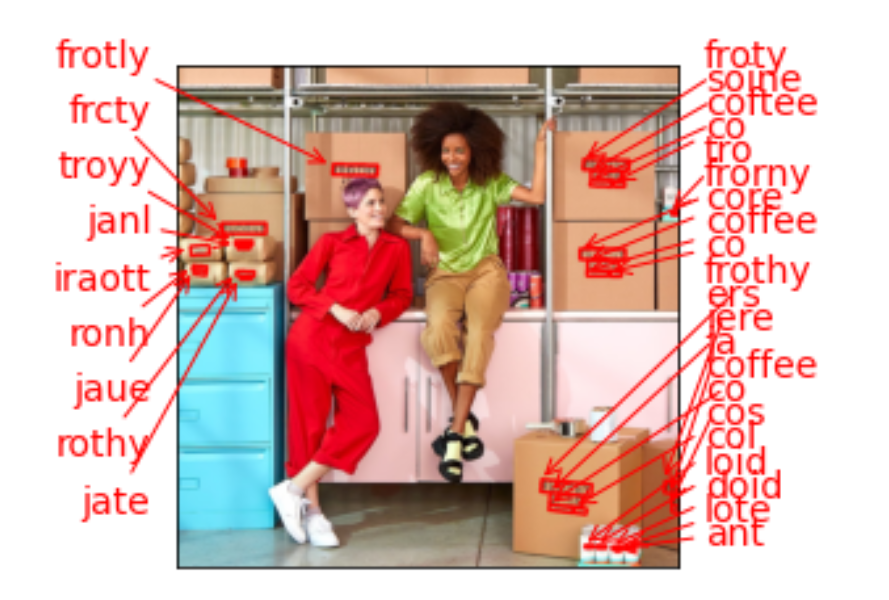

### Tesseract 사용

In [10]:
recognize_images(cropped_image_path_list)

PREDERY

A

COFFEE

to.

rico rin’

beh

COFFEE

ae

rROTRY

JO RE

COFFEE

CoO.

er.

Done


* keras-ocr경우 정확하지는 않지만 대체적으로 작은 글씨나 박스 위가 아닌 글자도 인식하는 것으로 보임.
* Tesseract 경우 시각적으로 볼 수 없어 아쉬우나 대충 다른 이미지들과 섞이지 않는 박스위 큰 글씨들만 인식하는 것으로 보임.

## Step4. 결과 분석과 결론 제시

Google OCR API의 사용시 결과가 월등히 좋았다고 하는데 시도 할 실력이 부족함.<br>
keras-ocr가 Tesseract 보다는 나은 인식을 보이나 단순한 단어의 스펠링을 틀리거나 일부가 가려진 글짜는 인식을 못하는 등 많이 부족해 보임.<br>
Google 번역기의 카메라-스캔 기능을 이용 시 편리함을 생각해 보면 Google OCR API이 제일 나을 것으로 생각됨.